# Multi input Keras Neural net - Image + Tabular data

This was trained in Google colab, so to access the data, it had to be uploaded to Google Drive and reached with the following snippet:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
from PIL import Image

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [3]:
# Paths in GDrive

path = "drive/MyDrive/"
deforestation_folder = "deforestation_train_test_data/"

## Data preprocessing

In [4]:
# Loading the labels and tabular data

df_train = pd.read_csv(path+deforestation_folder+"train.csv")
df_train_folds = pd.read_csv(path+deforestation_folder+"train_folds.csv")


In [5]:
df_train = df_train.merge(df_train_folds, on="example_path")

In [6]:
df_train["example_path"] = df_train.apply(lambda x: x["example_path"].replace("train_test_data", "deforestation_train_test_data"), axis=1)

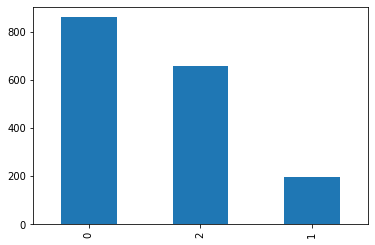

In [7]:
df_train['label'].value_counts().plot.bar()

Here we do two things:

- Load all the images, and convert them into numpy array format
- Resize them to 224x224 (As the ResNet50 pretrained on image net had this input size)

In [ ]:

X = []

for i, row in df_train.iterrows():
    print(i)
    im = Image.open(path + row.example_path).resize((224,224))
    image_array = np.asarray(im)
    X.append(image_array)

X = np.array(X)

np.save(path+deforestation_folder+"/X_224.npy", X)

# X = np.load(path+deforestation_folder+"/X_224.npy")

This here is super important!!! It applies the same preprocessing that was applied to imagenet when resnet50 was trained - If the same is not done to our data, the network does not perform well at all

In [9]:
X = preprocess_input(X)


In [10]:
y = df_train.label

In [11]:
X_train = X[df_train[df_train.fold!=0].index]
X_val = X[df_train[df_train.fold==0].index]

X_train_tabular = np.array(df_train[df_train.fold!=0][["latitude", "longitude", "year"]])
X_val_tabular = np.array(df_train[df_train.fold==0][["latitude", "longitude", "year"]])

In [12]:
X_train_tabular

array([[-2.05185262e+00,  1.11826093e+02,  2.00100000e+03],
       [ 1.22325629e+00,  1.00702217e+02,  2.01400000e+03],
       [-1.26555334e-01,  1.01758175e+02,  2.01100000e+03],
       ...,
       [ 3.81946392e+00,  1.17636112e+02,  2.01600000e+03],
       [ 4.43396596e-01,  1.12200163e+02,  2.01200000e+03],
       [-1.97834911e+00,  1.01970148e+02,  2.01200000e+03]])

In [13]:
y_train = y[df_train[df_train.fold!=0].index]
y_val = y[df_train[df_train.fold==0].index]

In [14]:
X_train.shape

(1371, 224, 224, 3)

In [15]:
X_val.shape

(343, 224, 224, 3)

## Modelling

We load ResNet50, set the layers as trainable and add it to the more complex model with multiinput

In [16]:
from tensorflow.keras.applications import resnet50

resnet = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [17]:
resnet.trainable = True

Model: "mixed_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_a (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['Input_a[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 100352)       0           ['resnet50[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 200)          20070600    ['flatten[0][0]']      

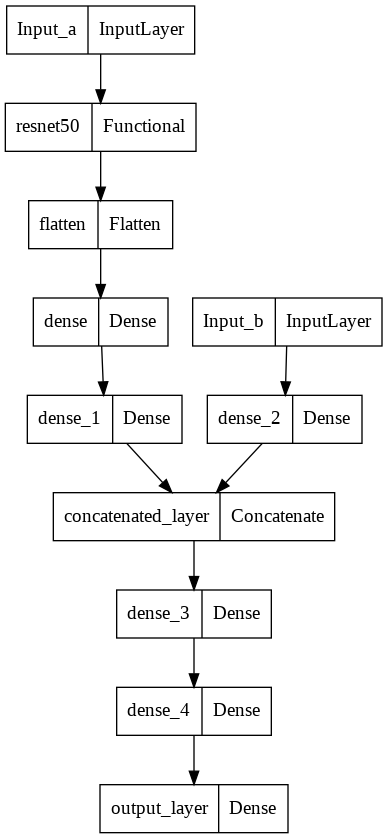

In [18]:
a_ip_img = Input(shape=(224, 224, 3), name="Input_a")
a_1 = resnet(a_ip_img)
a_2 = Flatten()(a_1)
a_4 = Dense(200, activation="relu")(a_2)
a_5 = Dense(50, activation="relu")(a_4)

b_ip_img = Input(shape=(3), name="Input_b")
b_1 = Dense(14, activation="relu")(b_ip_img)

a_b = concatenate([a_5,b_1], name="concatenated_layer")

a_b_1 = Dense(64, activation = "relu")(a_b)
a_b_2 = Dense(32, activation = "relu")(a_b_1)
output_layer = Dense(3, activation = "softmax", name = "output_layer")(a_b_2)

model = Model(inputs=[(a_ip_img,b_ip_img)], outputs=[output_layer], name = "mixed_model")

model.summary()

keras.utils.plot_model(model, show_shapes=False)

In order to be able to use the custom f1 function below, we have to transform the labels from logits into the sparse mode

In [19]:
y_val = np.array(pd.get_dummies(y_val))
y_train = np.array(pd.get_dummies(y_train))

## Data augmentation

In [20]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #rotation_range=50,
    #shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    [X_train, X_train_tabular], 
    y_train, 
    batch_size=64
)


In [21]:
def f1(y_true, y_pred):

    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

## Model training

Also very important!! If the learning rate is not lowered, since we are using a non-frozen pretrained resnet50, the training will not be stable at all

In [22]:
from tensorflow.keras.optimizers import Adam
new_adam = Adam(learning_rate=2e-5)

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=new_adam, metrics=['accuracy', f1])

Set up early stopping to avoid overfitting, with restore best weights

In [24]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights = True)
callback_val_f1 = EarlyStopping(monitor="val_f1", patience=15, mode="max", restore_best_weights = True)

In [25]:
epochs = 100 # Will stop with early stopping so a high number can be set

history = model.fit(train_generator, validation_data=([X_val, X_val_tabular], y_val), epochs=epochs, callbacks=[callback_val_loss, callback_val_f1])

Epoch 1/100
22/22 [==============================] - 40s 1s/step - loss: 61.8750 - accuracy: 0.3530 - f1: 0.2117 - val_loss: 55.6527 - val_accuracy: 0.3557 - val_f1: 0.2772
Epoch 2/100
22/22 [==============================] - 20s 890ms/step - loss: 18.9833 - accuracy: 0.5492 - f1: 0.4452 - val_loss: 25.7997 - val_accuracy: 0.5394 - val_f1: 0.3332
Epoch 3/100
22/22 [==============================] - 19s 837ms/step - loss: 4.6136 - accuracy: 0.7418 - f1: 0.5813 - val_loss: 21.6706 - val_accuracy: 0.5335 - val_f1: 0.2927
Epoch 4/100
22/22 [==============================] - 19s 844ms/step - loss: 2.5250 - accuracy: 0.7812 - f1: 0.6958 - val_loss: 20.3662 - val_accuracy: 0.5277 - val_f1: 0.2989
Epoch 5/100
22/22 [==============================] - 21s 935ms/step - loss: 1.9065 - accuracy: 0.8089 - f1: 0.7423 - val_loss: 16.0670 - val_accuracy: 0.5160 - val_f1: 0.2562
Epoch 6/100
22/22 [==============================] - 20s 912ms/step - loss: 1.4908 - accuracy: 0.8169 - f1: 0.7338 - val_loss:

In [29]:
from sklearn.metrics import f1_score

In [30]:
preds_classes = np.argmax(model.predict([X_val, X_val_tabular]), axis=-1)

11/11 [==============================] - 1s 101ms/step


In [31]:
f1_score(np.argmax(np.array(y_val), axis=1), preds_classes, average='macro')


0.7426027882417335